# Import Libraries

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

# Create a path to the dataset

In [3]:
path = Path('/kaggle/input/waste-classification-data/DATASET')
path.ls()

[PosixPath('/kaggle/input/waste-classification-data/DATASET/TEST'),
 PosixPath('/kaggle/input/waste-classification-data/DATASET/TRAIN')]

# Load the data in using the ImageDataBunch

Classes: 
 ['O', 'R']


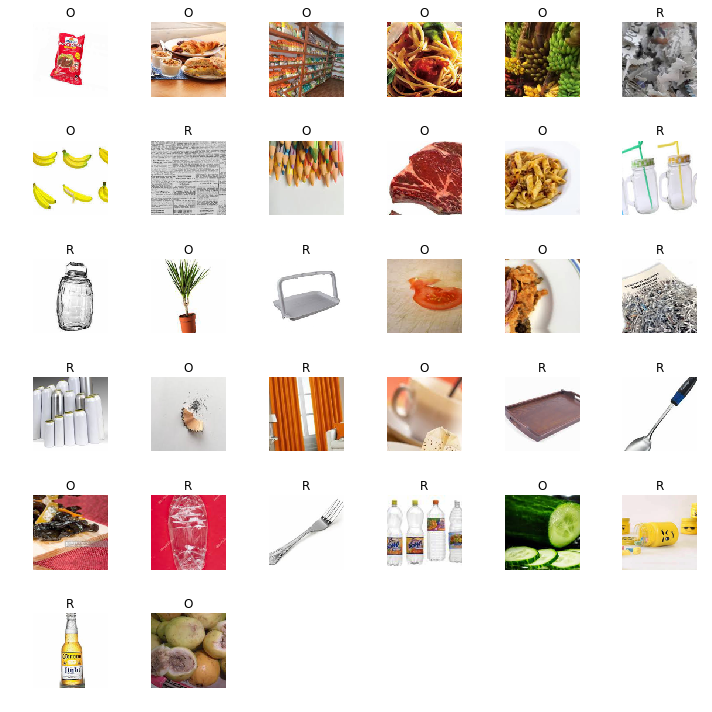

In [4]:
# Common Data Preparation
data = ImageDataBunch.from_folder(
    path,
    train="TRAIN",
    valid=0.2,
    test="TEST",
    ds_tfms=get_transforms(do_flip=False),
    size=128,
    bs=32,
    valid_pct=0.2,
    num_workers=0
).normalize(imagenet_stats)

print(f'Classes: \n {data.classes}')
data.show_batch(rows=10, figsize=(10, 10))




# Function to train and save the models


The `train_model` function trains and fine-tunes a model step by step. It starts by creating a learner for the given model and finding the best learning rate. Then, it trains the model for 5 epochs with frozen layers, updating only the last few layers, and plots the training and validation losses. After training, it evaluates the model by showing the top misclassified images and the confusion matrix. Next, it unfreezes all layers, finds a new learning rate, and trains the model again for 5 epochs with a learning rate range. Finally, it re-evaluates the model and saves it with a unique name.

In [5]:
from fastai.vision import *
import matplotlib.pyplot as plt

def train_model(model_arch, model_name):
    print(f"\nTraining {model_name}...\n")
    

    
    # Create a learner with the given model architecture
    learn = cnn_learner(data, model_arch, metrics=accuracy, model_dir='/tmp/model/')
    
    # Find the learning rate
    learn.lr_find()
    learn.recorder.plot(suggestion=True)
    
    # Initial Training with frozen layers
    learn.fit_one_cycle(5)
    learn.recorder.plot_losses()
    
    # Analyze results
    inter = ClassificationInterpretation.from_learner(learn)
    inter.plot_top_losses(9, figsize=(20, 20))
    inter.plot_confusion_matrix(figsize=(10, 10))
    
    # Fine-tuning
    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot(suggestion=True)
    learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))
    
    # Analyze results after fine-tuning
    learn.recorder.plot_losses()
    inter = ClassificationInterpretation.from_learner(learn)
    inter.plot_top_losses(9, figsize=(20, 20),heatmap=False)
    inter.plot_confusion_matrix(figsize=(10, 10))
    
    # Save the model
    learn.save(f'{model_name}-fastai-V1')
    print(f"\nModel {model_name} saved as {model_name}-fastai-V1\n")
    
    # Export the model for download
    learn.export(f'/kaggle/working/{model_name}.pkl')
    print(f"Model exported as {model_name}.pkl")
    print(f"Download your model from '/kaggle/working/{model_name}.pkl'")

# Train the models


Model resnet50 saved as resnet50-fastai-V1

Model exported as resnet50.pkl
Download your model from '/kaggle/working/resnet50.pkl'


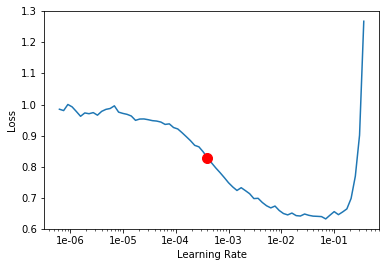

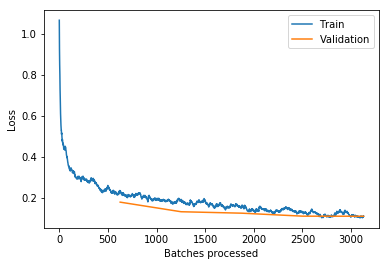

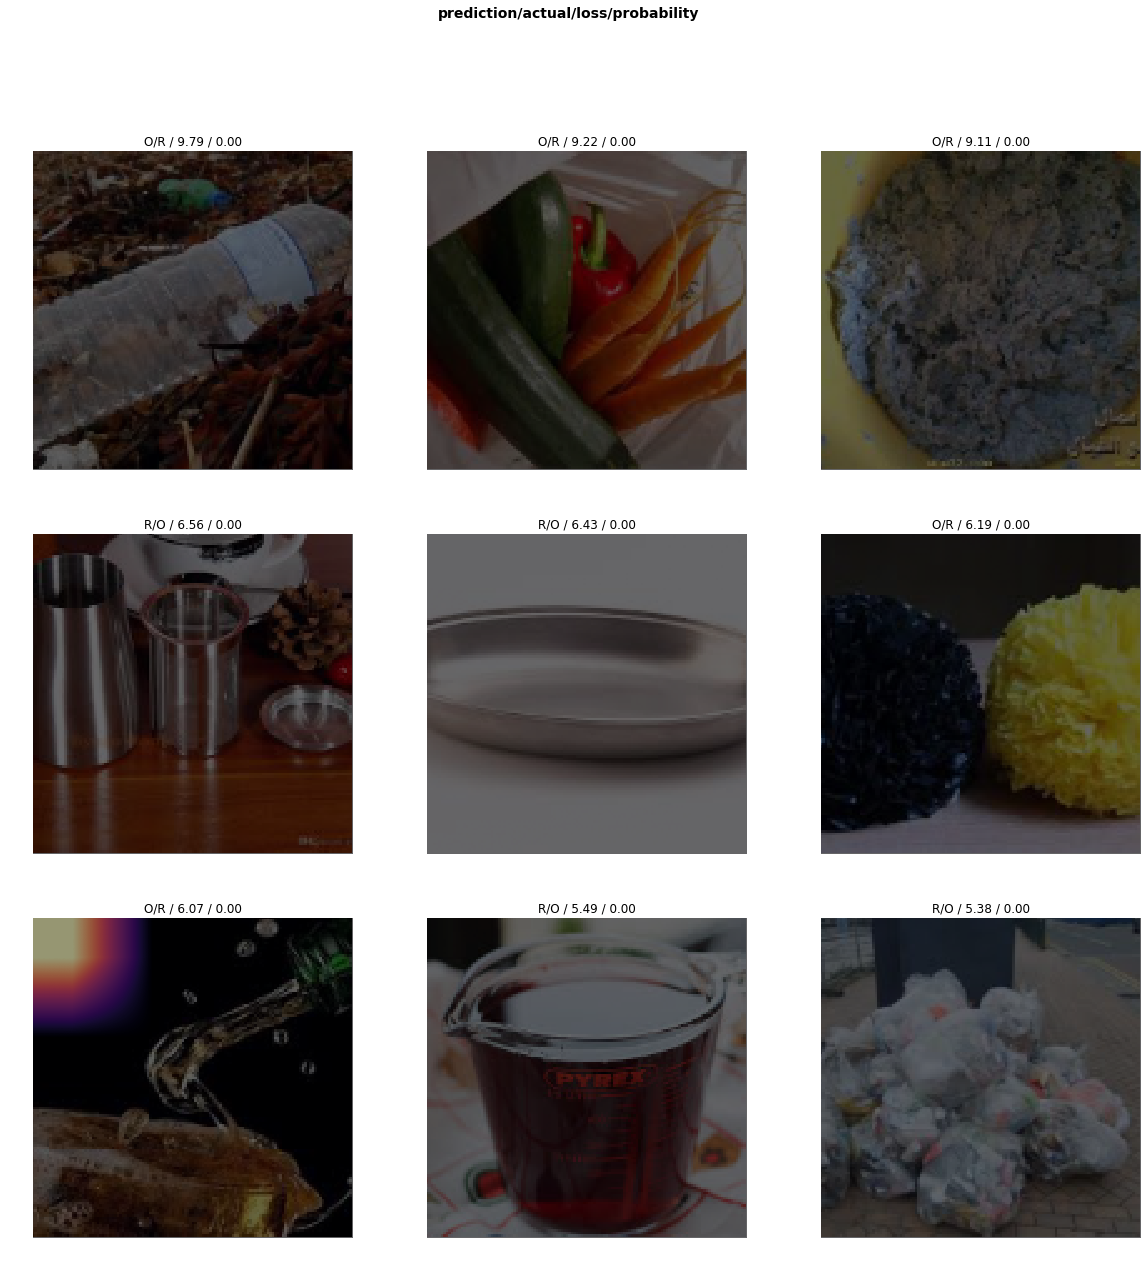

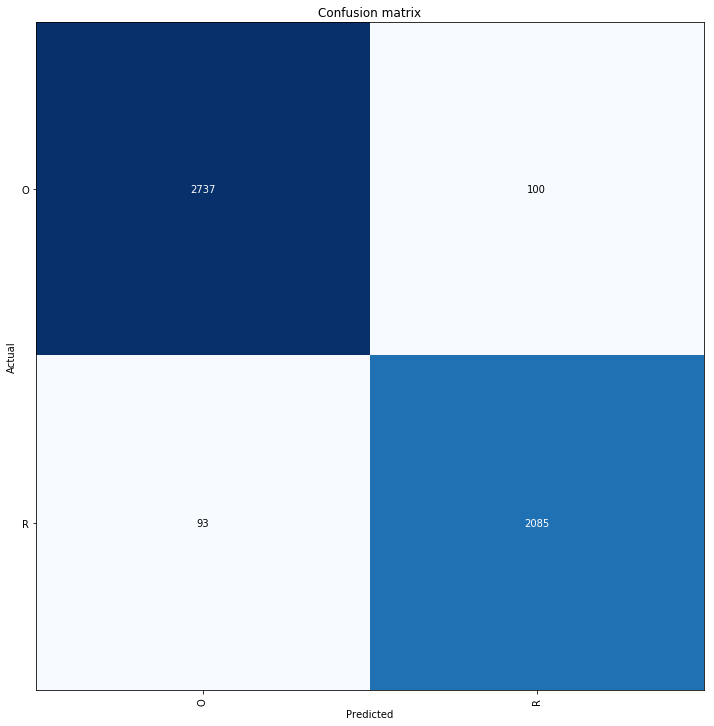

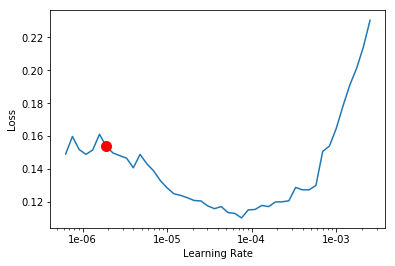

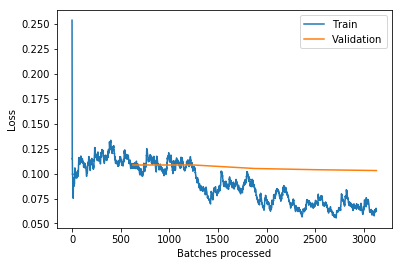

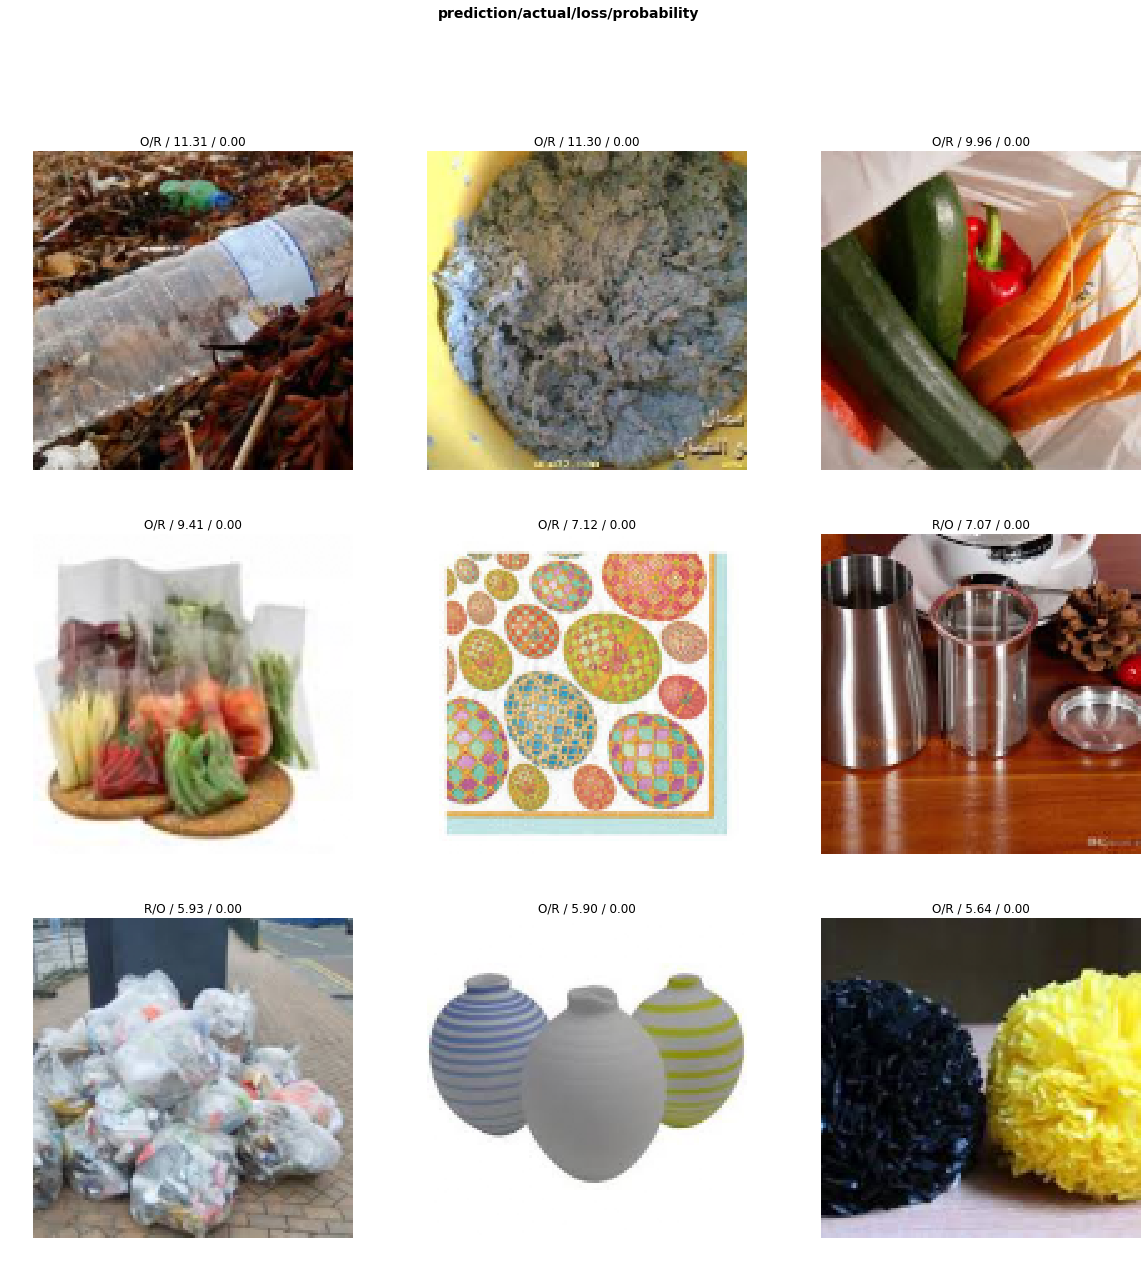

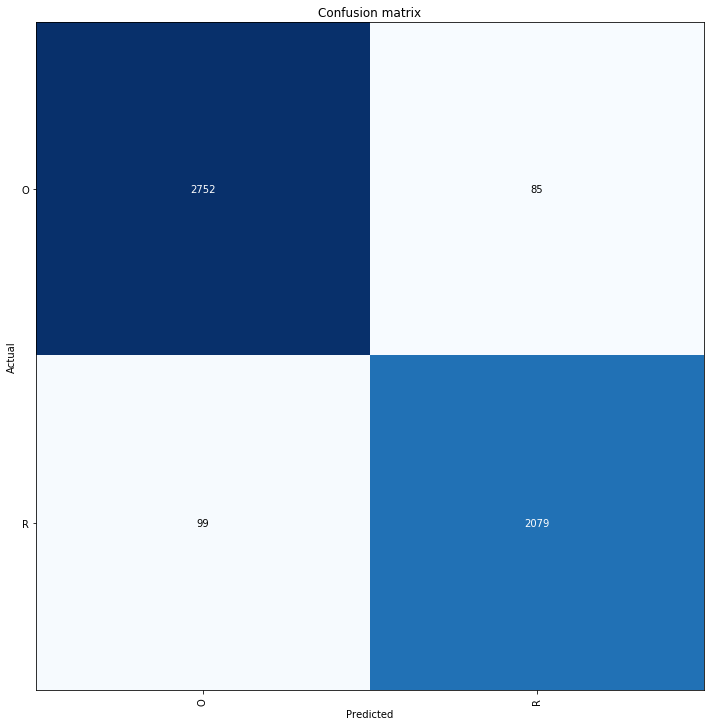

In [6]:
train_model(models.resnet50, "resnet50")


Model vgg16 saved as vgg16-fastai-V1

Model exported as vgg16.pkl
Download your model from '/kaggle/working/vgg16.pkl'


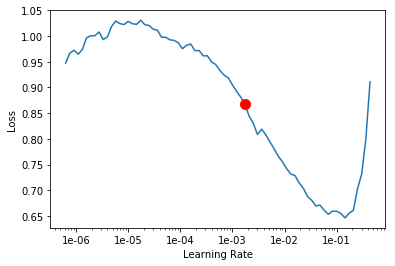

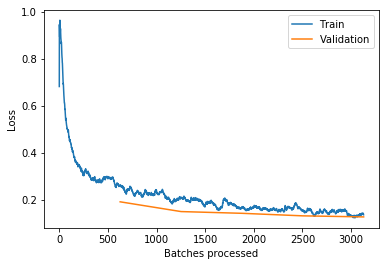

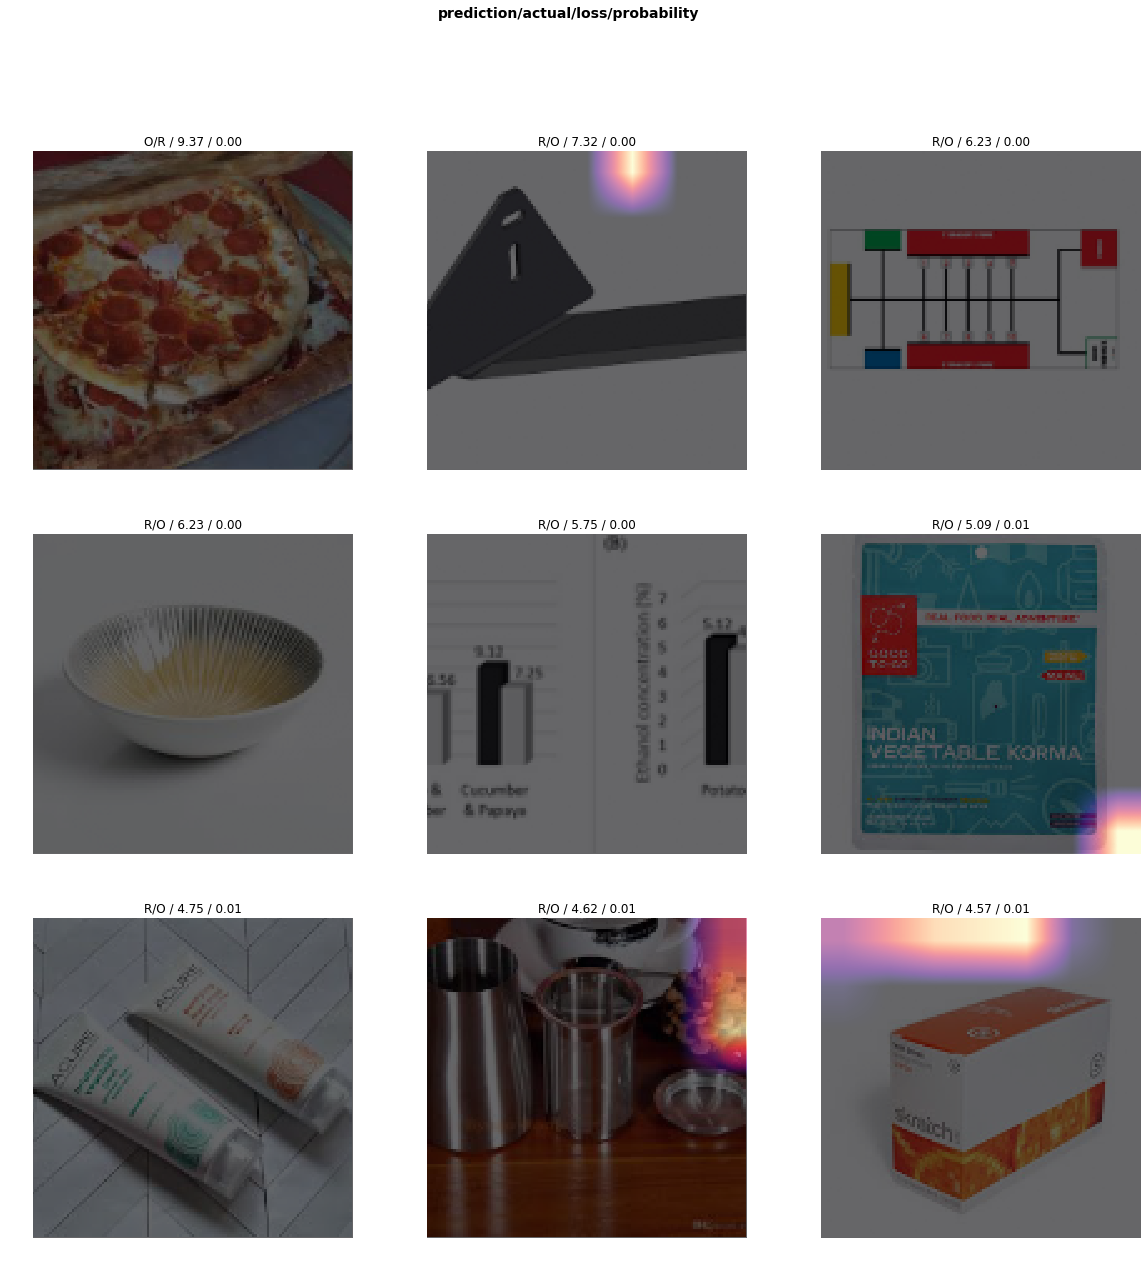

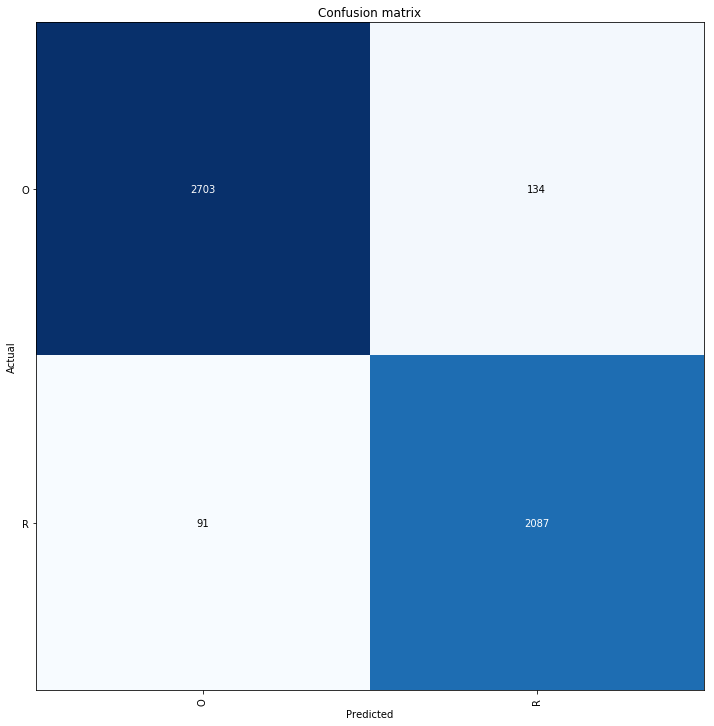

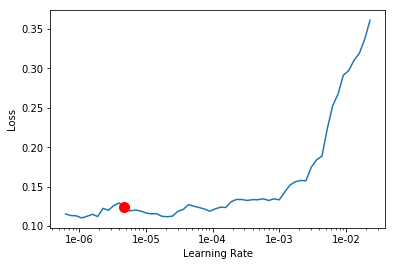

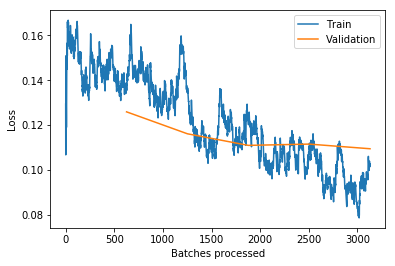

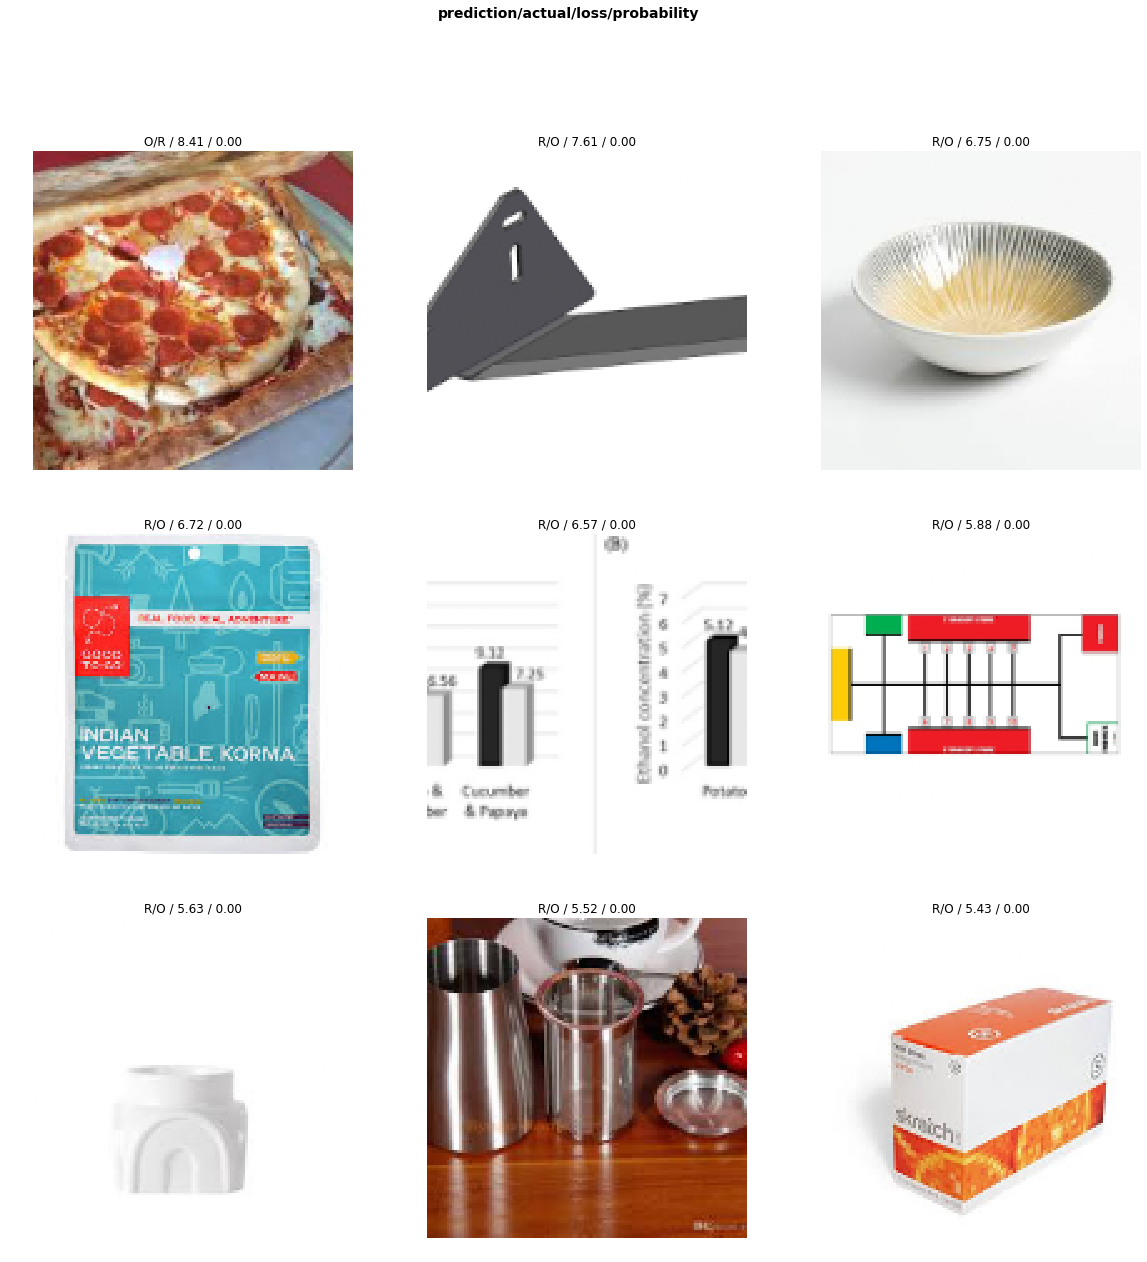

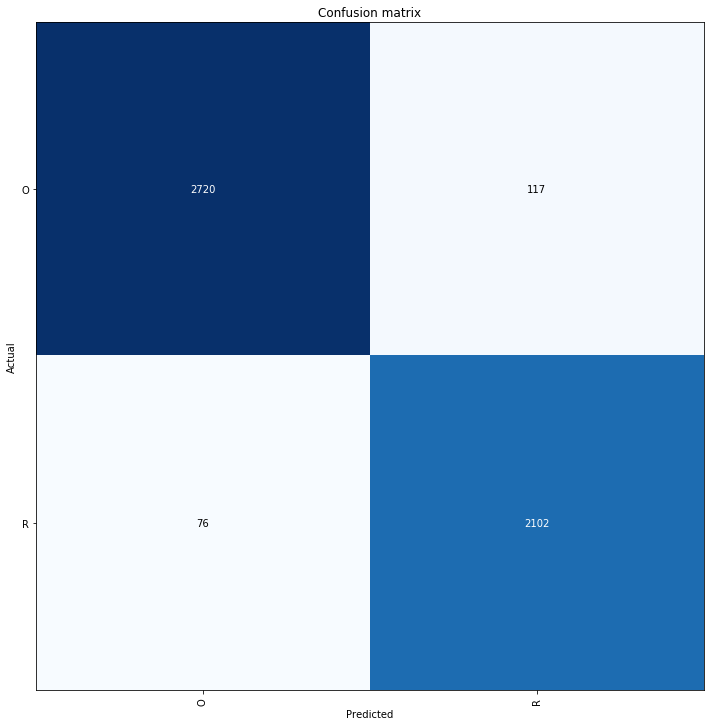

In [7]:
# Train VGG16
train_model(models.vgg16_bn, "vgg16")


Model densenet saved as densenet-fastai-V1

Model exported as densenet.pkl
Download your model from '/kaggle/working/densenet.pkl'


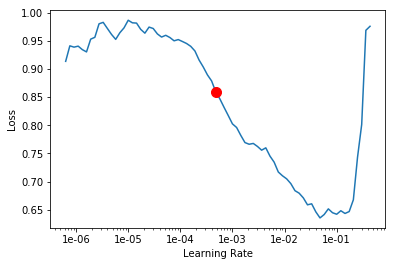

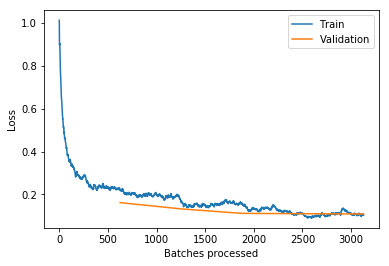

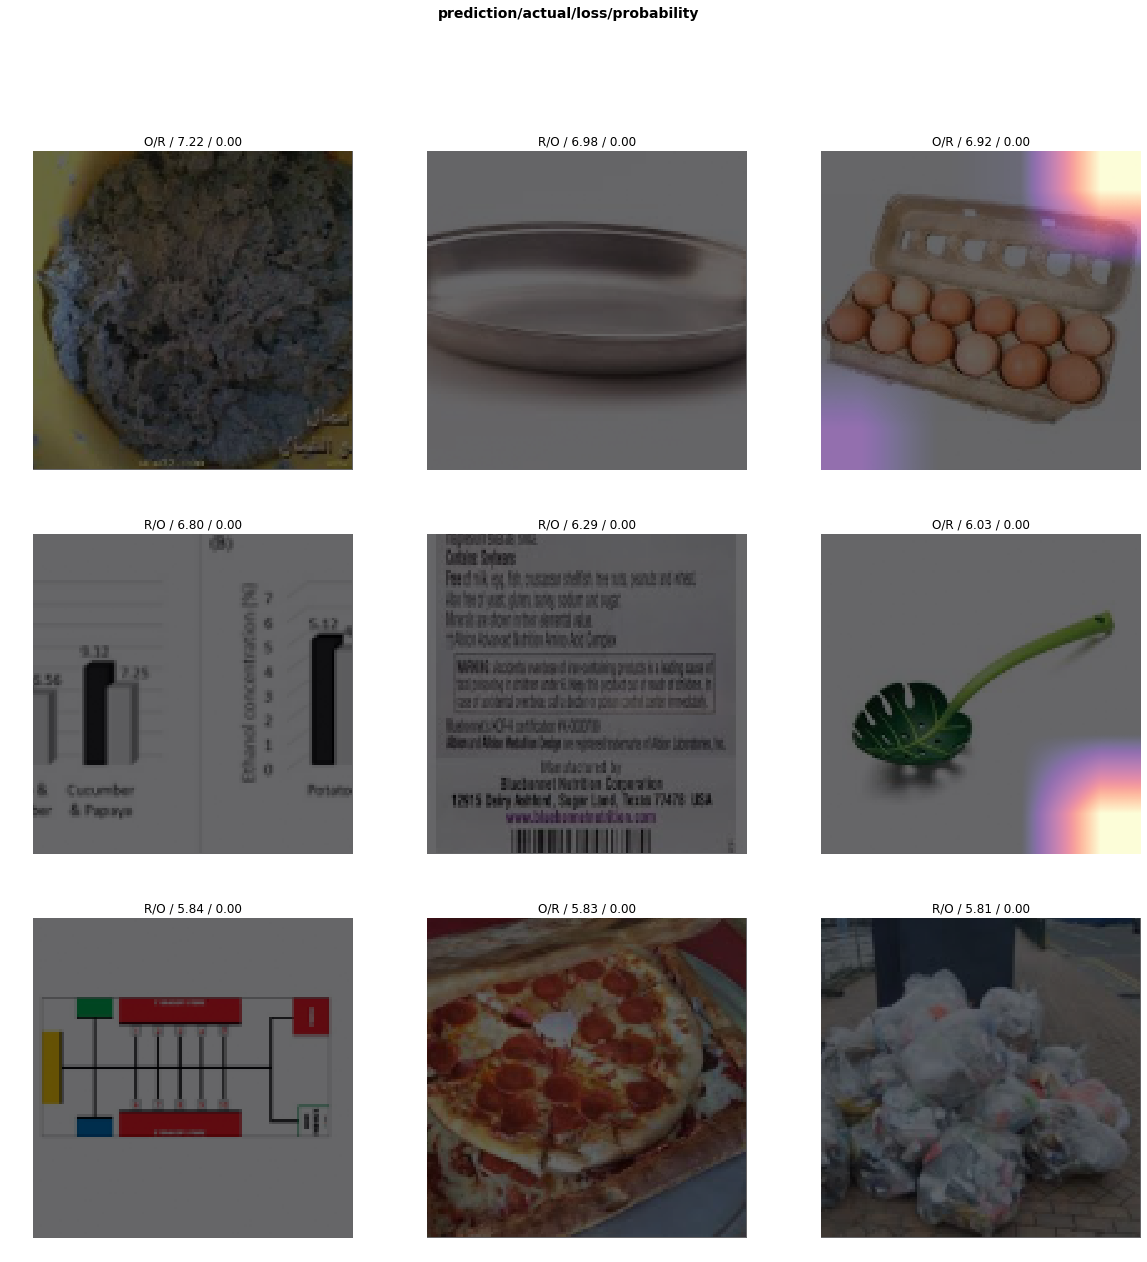

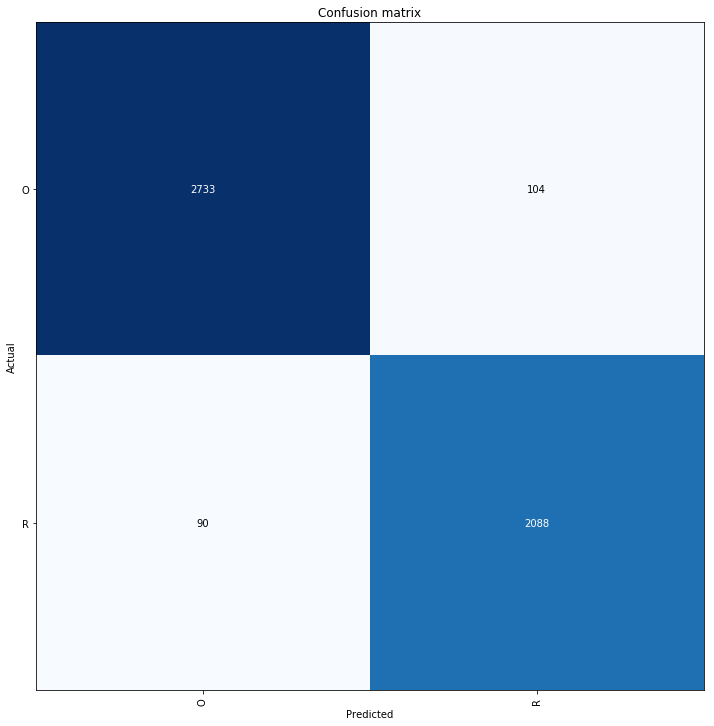

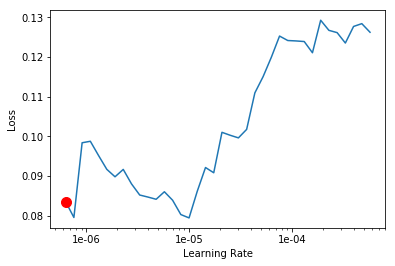

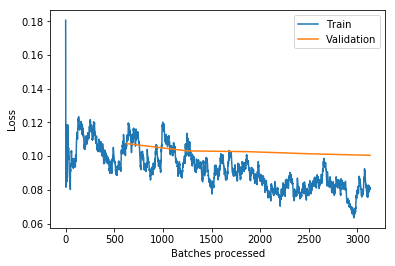

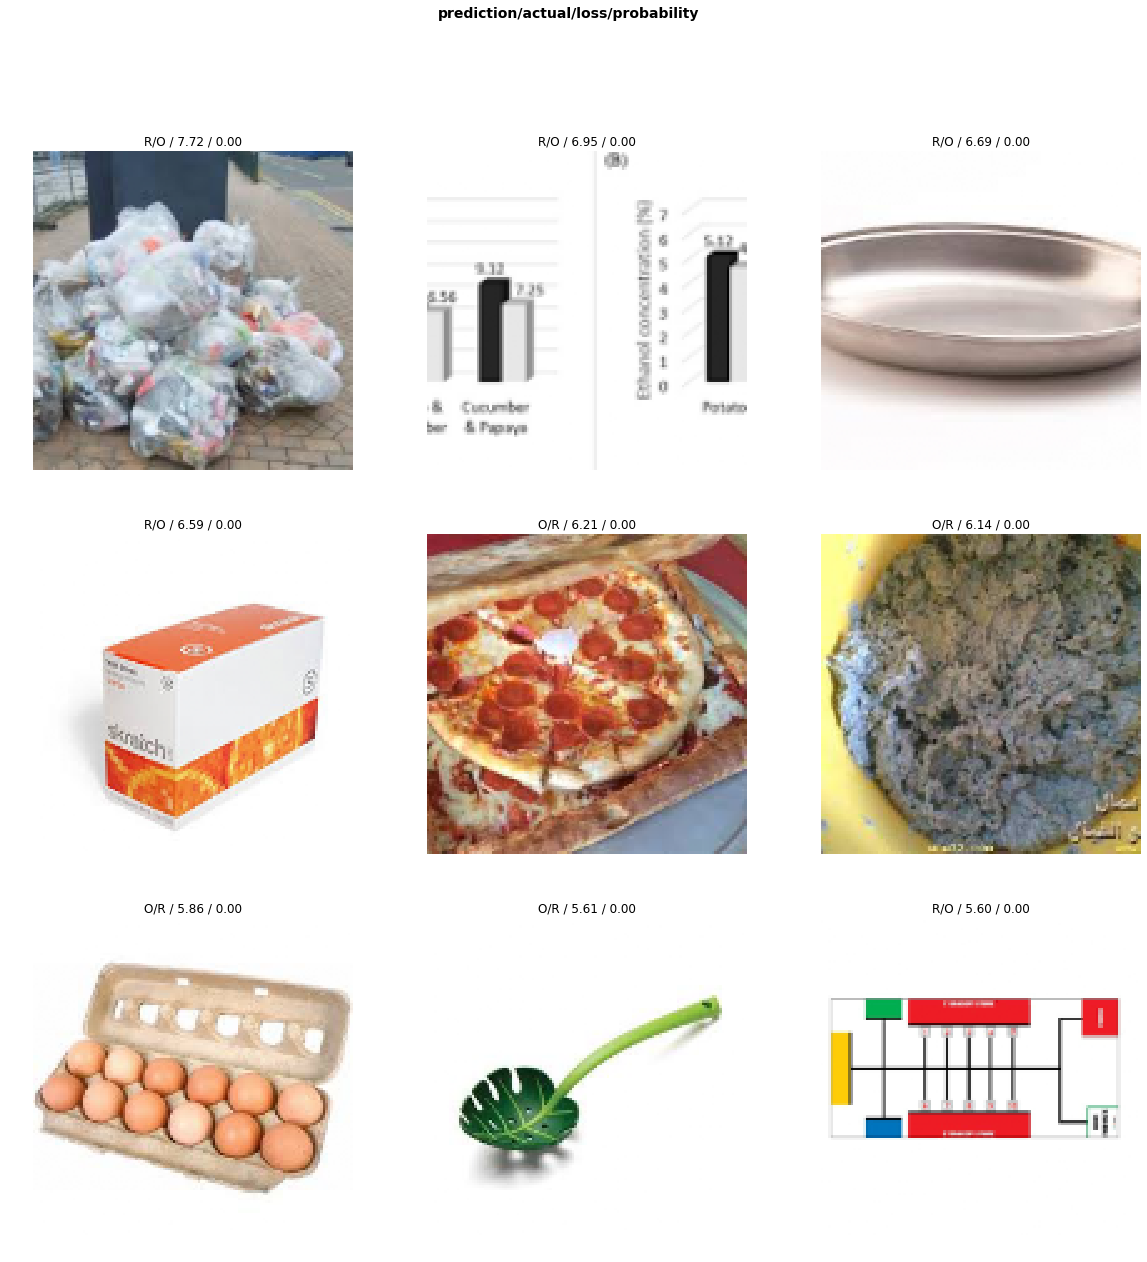

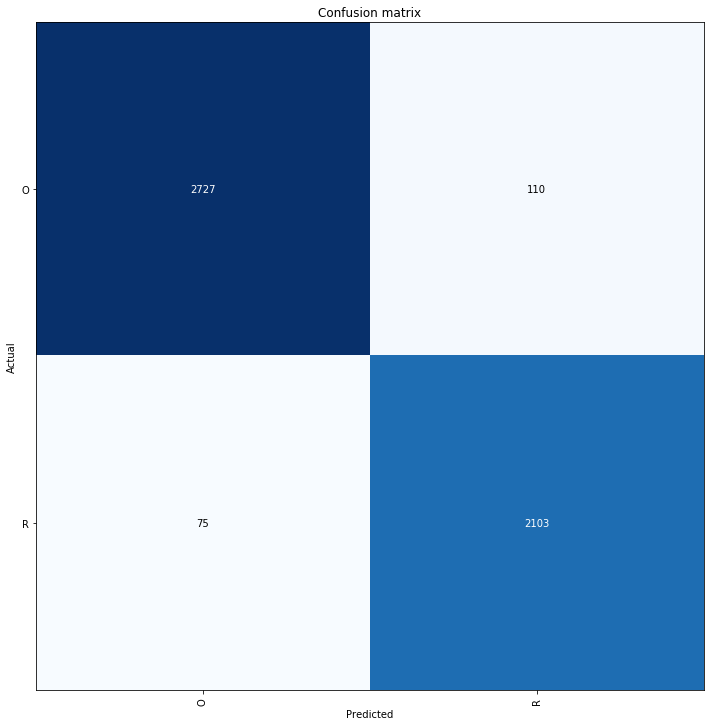

In [8]:
# Train DenseNet
train_model(models.densenet121, "densenet")

# Function for evaluation

In [9]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.vision import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

def evaluate_model(model_arch, model_name):
    # Load Model
    learn = cnn_learner(data, model_arch, metrics=accuracy, model_dir='/tmp/model/')
    learn.load(f'{model_name}-fastai-V1')

    test_path = Path(path) / "TEST"
    test_files = list(test_path.glob("**/*.jpg"))

    # Metrics Calculation
    y_true = []
    y_pred = []
    y_scores = []

    for img_path in test_files:
        img = open_image(img_path)
        pred_class, _, outputs = learn.predict(img)
        y_pred.append(pred_class.obj)
        y_true.append(img_path.parent.name)
        y_scores.append(outputs.softmax(dim=0).detach().cpu().numpy())

    # Convert labels to binary format for metric calculations
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    y_pred_bin = lb.transform(y_pred)
    y_scores = np.array(y_scores)

    # Compute Metrics
    accuracy_val = accuracy_score(y_true, y_pred)
    precision_val = precision_score(y_true_bin, y_pred_bin, average='macro')
    recall_val = recall_score(y_true_bin, y_pred_bin, average='macro')
    f1_val = f1_score(y_true_bin, y_pred_bin, average='macro')

    if len(lb.classes_) == 2:  # Binary classification
        auc_roc_val = roc_auc_score(y_true_bin, y_scores[:, 1])
    else:  # Multiclass classification
        auc_roc_val = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')

    # Print Metrics
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy  : {accuracy_val:.4f}")
    print(f"Precision : {precision_val:.4f}")
    print(f"Recall    : {recall_val:.4f}")
    print(f"F1 Score  : {f1_val:.4f}")
    print(f"AUC-ROC   : {auc_roc_val:.4f}")

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=lb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, 
                yticklabels=lb.classes_, annot_kws={"size": 14})  # Increase font size
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


# Evaluating the models


Model Evaluation Metrics:
Accuracy  : 0.9924
Precision : 0.9931
Recall    : 0.9916
F1 Score  : 0.9923
AUC-ROC   : 0.9997


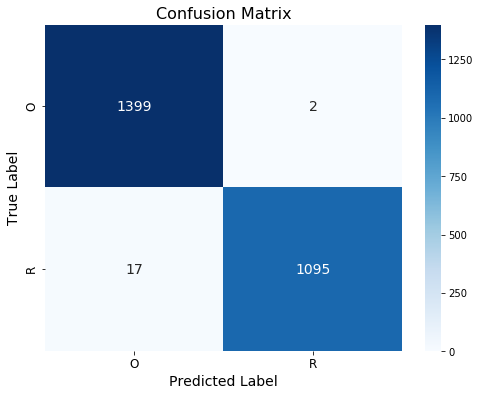

In [17]:
evaluate_model(models.resnet50, "resnet50")


Model Evaluation Metrics:
Accuracy  : 0.9885
Precision : 0.9889
Recall    : 0.9877
F1 Score  : 0.9883
AUC-ROC   : 0.9993


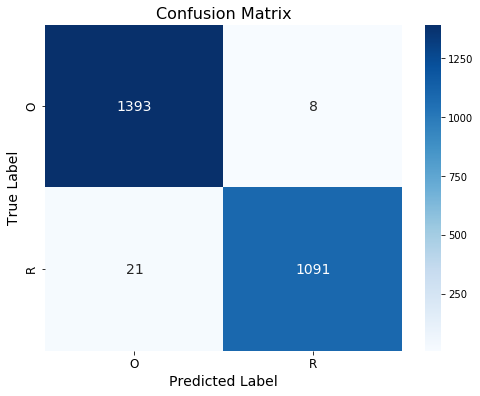

In [15]:
evaluate_model(models.vgg16_bn, "vgg16")


Model Evaluation Metrics:
Accuracy  : 0.9928
Precision : 0.9932
Recall    : 0.9923
F1 Score  : 0.9927
AUC-ROC   : 0.9997


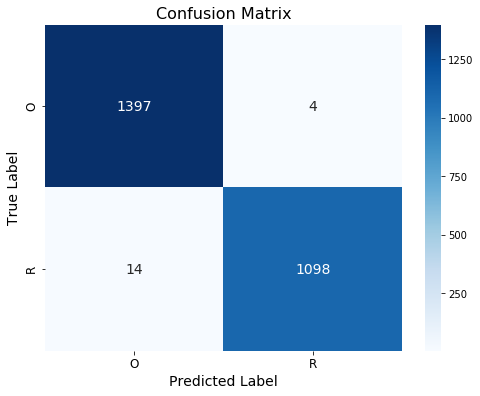

In [16]:
evaluate_model(models.densenet121, "densenet")